# CA hospitals

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()
from selenium import webdriver
driver = webdriver.Chrome(executable_path='/Users/mhustiles/Desktop/chromedriver')

### Hospital building characteristics

In [2]:
#https://data.chhs.ca.gov/dataset/hospital-building-data
#Metadata: https://data.chhs.ca.gov/dataset/hospital-building-data/resource/cefc10e5-5071-4ca4-8b03-2249caf0d294
buildings = pd.read_csv('input/ca-oshpd-gachospital-building-03052020.csv', encoding='Latin-1',\
                        dtype={'year_completed': object, 'building_code_year': object, 'stories': int,\
                               'height_ft': int}).fillna('')

In [3]:
buildings.columns = buildings.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [4]:
buildings.head()

,county_code,perm_id,facility_name,city,building_nbr,building_name,building_status,spc_rating_*,building_url,height_ft,stories,building_code,building_code_year,year_completed,latitude,longitude,count
0,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01278,Original Hospital,In Service,1,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,44.17,4,Unknown,,1926,37.762657,-122.253899,1
1,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01279,Stephens Wing,In Service,1,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,35,3,1952 Uniform Building Code (UBC),1952,1956,37.762657,-122.253899,1
2,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01280,West Wing,In Service,2,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,2,1964 Uniform Building Code (UBC),1964,1968,37.762657,-122.253899,1
3,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01281,South Wing,In Service,3s,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,3,1976 California Building Code (CBC),1976,1983,37.762657,-122.253899,1
4,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01282,Radiology Addition,In Service,5s,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,2,1985 California Building Code (CBC),1985,1995,37.762657,-122.253899,1


In [5]:
buildings_geo = gpd.GeoDataFrame(
    buildings, geometry=gpd.points_from_xy(buildings.longitude, buildings.latitude))

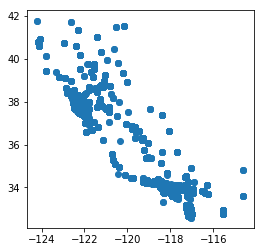

In [6]:
buildings_geo.plot()

--- 

### Facility listing

In [7]:
#https://data.chhs.ca.gov/dataset/healthcare-facility-locations/resource/0a0476ba-442c-40ff-97dc-dc840fa7e907
facilities = pd.read_excel('input/healthcare_facility_locations.xlsx')

In [8]:
facilities.columns = facilities.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [9]:
facilities_geo = gpd.GeoDataFrame(
    facilities, geometry=gpd.points_from_xy(facilities.longitude, facilities.latitude))

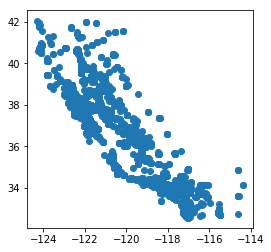

In [10]:
facilities_geo.plot()

In [11]:
hospitals = facilities_geo[facilities_geo['fac_type_code'] == 'GACH']

In [12]:
hospitals['entity_type_description'].value_counts()

NONPROFIT CORP               215
LIMITED LIABILITY COMPANY     65
PROFIT CORP                   49
HEALTH CARE DISTRICT          34
PARTNERSHIP                   19
COUNTY                        17
UC REGENT                      9
OTHER PUBLIC AGENCY            5
INDIVIDUAL                     1
STATE AGENCY                   1
CITY                           1
Name: entity_type_description, dtype: int64

In [13]:
hospitals.head()

,facid,npi,facname,fac_type_code,fac_fdr,ltc,capacity,address,city,zip,zip9,facadmin,contact_email,contact_fax,contact_phone_number,county_code,county_name,district_number,district_name,isfacmain,license_number,business_name,initial_license_date,license_effective_date,license_expiration_date,entity_type_description,latitude,longitude,location,oshpd_id,streetnum,streetname,cclho_code,cclho_name,fips_county_code,birthing_facility_flag,trauma_ped_ctr,trauma_ctr,type_of_care,critical_access_hospital,geometry
243,30000037,1467560599,METHODIST HOSPITAL OF SACRAMENTO,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,158,7500 HOSPITAL DRIVE,SACRAMENTO,95823,5403.0,"BALTZ, PHYLLIS A",MARI.SHELTON@DIGNITYHEALTH.ORG,(916) 423-6045,(916) 423-3000,440,SACRAMENTO,3,SACRAMENTO,Y,30000064.0,DIGNITY COMMUNITY CARE,1980-06-30,2019-12-31,2020-12-30,NONPROFIT CORP,38.463530,-121.416061,"(-121.416061,38.46353)",106340951.0,7500,HOSPITAL DRIVE,34,SACRAMENTO,6067,YES,NaN,NaN,NaN,NaN,POINT (-121.41606 38.46353)
261,30000108,1447494323,SUTTER AMADOR HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,52,200 MISSION BOULEVARD,JACKSON,95642,2564.0,"DICKSON, THOMAS",SAMMOND@SUTTERHEALTH.ORG,(209) 223-7454,(209) 223-7500,20,AMADOR,3,SACRAMENTO,Y,30000008.0,SUTTER VALLEY HOSPITALS,1979-05-01,2019-11-01,2020-10-31,NONPROFIT CORP,38.350190,-120.764621,"(-120.764621,38.35019)",106034002.0,200,MISSION BOULEVARD,3,AMADOR,6005,YES,NaN,NaN,NaN,NaN,POINT (-120.76462 38.35019)
262,30000109,1194774299,SUTTER AUBURN FAITH HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,64,11815 EDUCATION STREET,AUBURN,95602,2410.0,"HANNA, MITCHELL J",ZOBELC@SUTTERHEALTH.ORG,(530) 886-6611,(530) 888-4557,410,PLACER,3,SACRAMENTO,Y,30000012.0,SUTTER VALLEY HOSPITALS,1966-06-30,2019-07-26,2020-05-30,NONPROFIT CORP,38.945570,-121.100331,"(-121.100331,38.94557)",106310791.0,11815,EDUCATION STREET,31,PLACER,6061,NaN,NaN,NaN,NaN,NaN,POINT (-121.10033 38.94557)
263,30000113,1710918545,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,625,2315 STOCKTON BOULEVARD,SACRAMENTO,95817,2201.0,"SIMMONS, BRADLEY",LTNAVARRA@UCDAVIS.EDU,(916) 734-3234,(916) 734-2011,440,SACRAMENTO,3,SACRAMENTO,Y,30000086.0,UNIVERSITY OF CALIFORNIA BOARD OF REGENTS,1953-08-26,2019-12-06,2020-04-07,UC REGENT,38.554290,-121.455181,"(-121.455181,38.55429)",106341006.0,2315,STOCKTON BOULEVARD,34,SACRAMENTO,6067,YES,LEVEL I PED,LEVEL I,NaN,NaN,POINT (-121.45518 38.55429)
264,30000114,1003867565,BARTON MEMORIAL HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,63,2170 SOUTH AVENUE,SOUTH LAKE TAHOE,96150,7025.0,"PURVANCE, CLINTON D",PUBLICRELATIONS@BARTONHEALTH.ORG,(530) 541-4697,(530) 541-3420,80,EL DORADO,3,SACRAMENTO,Y,30000013.0,BARTON HEALTHCARE SYSTEM,1963-11-21,2019-07-11,2020-06-29,NONPROFIT CORP,38.912319,-119.996583,"(-119.996583,38.912319)",106090793.0,2170,SOUTH AVENUE,9,EL DORADO,6017,YES,NaN,LEVEL III,NaN,NaN,POINT (-119.99658 38.91232)


In [14]:
public_list = ['COUNTY','UC REGENT','OTHER PUBLIC AGENCY','CITY','STATE AGENCY']

In [15]:
public = hospitals[hospitals['entity_type_description'].isin(public_list)]

In [16]:
public.to_csv('output/public_hospitals_from_chhs.csv')

In [17]:
public.contact_email.tolist()

['LTNAVARRA@UCDAVIS.EDU',
 'INFO@SJGH.ORG',
 nan,
 'DFINLEY@DHS.LACOUNTY.GOV',
 'LZMARTINEZ@DHS.LACOUNTY.GOV',
 nan,
 'DCASTILLO@DHS.LACOUNTY.GOV',
 'DBOURGET@UCI.EDU',
 'LICENSINGANDCERTIFICATION@NATIVIDAD.COM',
 'PATRYAN@VERITY.ORG',
 'HOSPITAL.ADMIN@HHS.SCCGOV.ORG',
 'CORRIERUDD@VERIFY.ORG',
 'ADOLPHE.EDWARD@ECRMC.ORG',
 'POLSEN@UCSD.EDU',
 nan,
 'RON.EYRAUD@KERNMEDICAL.COM',
 'RISKMANAGEMENT@ALAMEDAHEALTHSYSTEM.ORG',
 nan,
 'ADALY@ACMEDCTR.ORG',
 'JASPREET.BENEPAL@CCHEALTH.ORG',
 nan,
 'CKUNNAPPILLY@SMCGOV.ORG',
 nan,
 nan,
 nan,
 nan,
 'HOGGANE@ARMC.SBCOUNTY.GOV',
 nan,
 nan,
 'JAJACKSON@ACMEDCTR.ORG',
 nan,
 'PWATKINS@MEDNET.UCLA.EDU',
 'MBWILLIS@MEDNET.UCLA.EDU']

In [18]:
len(public)

33

In [19]:
public.head()

,facid,npi,facname,fac_type_code,fac_fdr,ltc,capacity,address,city,zip,zip9,facadmin,contact_email,contact_fax,contact_phone_number,county_code,county_name,district_number,district_name,isfacmain,license_number,business_name,initial_license_date,license_effective_date,license_expiration_date,entity_type_description,latitude,longitude,location,oshpd_id,streetnum,streetname,cclho_code,cclho_name,fips_county_code,birthing_facility_flag,trauma_ped_ctr,trauma_ctr,type_of_care,critical_access_hospital,geometry
263,30000113,1710918545,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,625,2315 STOCKTON BOULEVARD,SACRAMENTO,95817,2201.0,"SIMMONS, BRADLEY",LTNAVARRA@UCDAVIS.EDU,(916) 734-3234,(916) 734-2011,440,SACRAMENTO,3,SACRAMENTO,Y,30000086.0,UNIVERSITY OF CALIFORNIA BOARD OF REGENTS,1953-08-26,2019-12-06,2020-04-07,UC REGENT,38.554290,-121.455181,"(-121.455181,38.55429)",106341006.0,2315,STOCKTON BOULEVARD,34,SACRAMENTO,6067,YES,LEVEL I PED,LEVEL I,NaN,NaN,POINT (-121.45518 38.55429)
279,30000135,1275605180,SAN JOAQUIN GENERAL HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,152,500 W. HOSPITAL ROAD,FRENCH CAMP,95231,9693.0,"CULBERSON, DAVID",INFO@SJGH.ORG,(209) 468-7011,(209) 468-6000,490,SAN JOAQUIN,3,SACRAMENTO,Y,30000087.0,COUNTY OF SAN JOAQUIN,1953-07-01,2020-01-01,2020-10-31,COUNTY,37.886550,-121.282211,"(-121.282211,37.88655)",106391010.0,500,W. HOSPITAL ROAD,39,SAN JOAQUIN,6077,YES,NaN,LEVEL III,NaN,NaN,POINT (-121.28221 37.88655)
698,50000039,1629167457,VENTURA COUNTY MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,180,300 HILLMONT AVE,VENTURA,93003,3099.0,"FANKHAUSER, JOHN",NaN,(805) 652-6169,(805) 652-6075,660,VENTURA,5,VENTURA,Y,50000032.0,COUNTY OF VENTURA,1953-07-01,2020-03-01,2021-02-28,COUNTY,34.279145,-119.254337,"(-119.254337,34.279145)",106560481.0,300,HILLMONT AVE,56,VENTURA,6111,YES,NaN,LEVEL II,NaN,NaN,POINT (-119.25434 34.27914)
918,60000027,1295757938,LAC/HARBOR UCLA MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,415,1000 W CARSON ST,TORRANCE,90502,2004.0,"MCKENZIE, KIMBERLY",DFINLEY@DHS.LACOUNTY.GOV,(310) 328-9624,(310) 222-2345,200,LOS ANGELES,6,ORANGE,Y,60000129.0,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,1953-07-01,2019-05-01,2020-04-30,COUNTY,33.831540,-118.294551,"(-118.294551,33.83154)",106191227.0,1000,W CARSON ST,19,LOS ANGELES,6037,YES,LEVEL II PED,LEVEL I,NaN,NaN,POINT (-118.29455 33.83154)
919,60000028,1336156363,LAC/RANCHO LOS AMIGOS NATIONAL REHABILITATION ...,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,158,7601 IMPERIAL HWY,DOWNEY,90242,3456.0,"OROZCO, JORGE",LZMARTINEZ@DHS.LACOUNTY.GOV,(562) 803-0056,(562) 385-7022,200,LOS ANGELES,6,ORANGE,Y,60000161.0,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,1953-07-01,2020-01-23,2020-03-30,COUNTY,33.929100,-118.158001,"(-118.158001,33.9291)",106191306.0,7601,IMPERIAL HWY,19,LOS ANGELES,6037,NaN,NaN,NaN,NaN,NaN,POINT (-118.15800 33.92910)


---

---

### CHHS: Hospital Annual Utilization Report - 2018

In [20]:
# https://data.chhs.ca.gov/dataset/hospital-annual-utilization-report
# pivot table: https://data.chhs.ca.gov/dataset/hospital-annual-utilization-report/resource/4ee65e8c-ca6e-42d3-9aec-adcc56383856

In [21]:
utilization = pd.read_csv('input/2018_hosp_util_pivot_20191231.csv')

In [22]:
utilization.iloc[0]

oshpd_id                                                                  106010735
FAC_NO                                                                    106010735
FAC_NAME                                                           ALAMEDA HOSPITAL
FAC_STR_ADDR                                                       2070 CLINTON AVE
FAC_CITY                                                                    ALAMEDA
FAC_ZIP                                                                       94501
FAC_OPERATED_THIS_YR                                                            Yes
FAC_OP_PER_BEGIN_DT                                                      01/01/2018
FAC_OP_PER_END_DT                                                        12/31/2018
FAC_PAR_CORP_NAME                                             Alameda Health System
LICENSE_NO                                                                140000002
LICENSE_EFF_DATE                                                         10/

In [23]:
utilization.columns = utilization.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [24]:
utilization.rename(columns={"ic_cen_days": "icu_days", "ic_lic_bed_days": "icu_bed_days",\
                     'ic_lic_beds':'icu_beds', 'tot_lic_beds': 'total_beds'}, inplace=True)

In [25]:
utilization.head()

,oshpd_id,fac_no,fac_name,fac_str_addr,fac_city,fac_zip,fac_operated_this_yr,fac_op_per_begin_dt,fac_op_per_end_dt,fac_par_corp_name,license_no,license_eff_date,license_exp_date,license_status,facility_level,trauma_ctr,teach_hosp,teach_rural,longitude,latitude,assembly_dist,senate_dist,congress_dist,cens_tract,med_svc_study_area,...,level_i_trauma,level_ii_trauma,level_iii_trauma,level_iv_trauma,emsa_ped,level_i_ped,level_ii_ped,level_iii_ped,level_iv_ped,emsa_trauma,emsa_either,non_emsa,level_i_visit,level_ii_visit,level_iii_visit,level_iv_visit,non_emsa_visit,minor_tot,lowm_tot,mod_tot,sev_tot,crit_tot,unk_acuity_not_adm,unk_acuity_adm,unknown_sev
0,106010735,106010735,ALAMEDA HOSPITAL,2070 CLINTON AVE,ALAMEDA,94501,Yes,01/01/2018,12/31/2018,Alameda Health System,140000002,10/30/2018,04/30/2019,Open,Parent Facility,NaN,No,No,-122.253991,37.76266,District 18,District 09,District 13,6.001428e+09,2e,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,16469,762,2871,6566,4226,2044,0,0,0
1,106010739,106010739,ALTA BATES SUMMIT MEDICAL CENTER-ALTA BATES CA...,2450 ASHBY AVENUE,BERKELEY,94705,Yes,01/01/2018,12/31/2018,Sutter Health,140000004,11/01/2017,10/31/2018,Open,Parent Facility,NaN,No,No,-122.257430,37.85645,District 15,District 09,District 13,6.001424e+09,2b,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,45958,545,3819,10529,15099,10614,0,5352,5352
2,106010776,106010776,UCSF BENIOFF CHILDREN'S HOSPITAL OAKLAND,747 52ND STREET,OAKLAND,94609,Yes,01/01/2018,12/31/2018,NaN,140000015,11/20/2018,12/31/2018,Open,Parent Facility,Level I - Pediatric,No,No,-122.267470,37.83722,District 15,District 09,District 13,6.001401e+09,2c,...,0,0,0,0,1,1,0,0,0,1,1,0,44808,0,0,0,0,821,7810,22156,6758,7263,0,0,0
3,106010811,106010811,FAIRMONT HOSPITAL,15400 FOOTHILL BOULEVARD,SAN LEANDRO,94578,Yes,01/01/2018,12/31/2018,Alameda Health System,140000046,11/01/2018,10/31/2019,Open,Consolidated Facility,NaN,No,No,-122.118190,37.70648,District 20,District 10,District 15,6.001430e+09,2f,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,106010844,106010844,ALTA BATES SUMMIT MEDICAL CENTER-HERRICK CAMPUS,2001 DWIGHT WAY,BERKELEY,94704,Yes,01/01/2018,12/31/2018,Sutter Health,140000004,11/01/2017,10/31/2018,Open,Consolidated Facility,NaN,No,No,-122.269840,37.86373,District 15,District 09,District 13,6.001423e+09,2a,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
utilization['icu_occupancy_rate_2018'] = ((utilization.icu_days / utilization.icu_bed_days)*100).round()

In [27]:
utilization_geo = gpd.GeoDataFrame(
    utilization, geometry=gpd.points_from_xy(utilization.longitude, utilization.latitude))

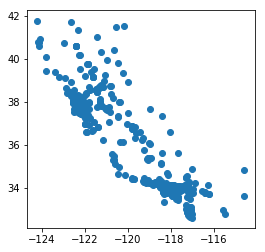

In [28]:
utilization_geo.plot()

In [29]:
utilization_counties = pd.DataFrame(utilization_geo.groupby(['county']).agg({'total_beds':'sum','icu_days':'sum', 'icu_bed_days':'sum', \
                                                  'icu_beds':'sum', 'icu_occupancy_rate_2018':'mean'}).reset_index())

In [30]:
utilization_counties.sort_values(by='icu_beds', ascending=False).head()

,county,total_beds,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate_2018
17,Los Angeles,27111.0,462032.0,780420.0,2174.0,66.244186
28,Orange,8016.0,127304.0,232259.0,631.0,57.275862
35,San Diego,7361.0,126475.0,212362.0,540.0,62.600000
34,San Bernardino,5988.0,126567.0,181040.0,496.0,62.150000
31,Riverside,4068.0,75210.0,136506.0,378.0,56.166667


In [66]:
utilization_counties.fillna('').to_csv('output/icu_by_county.csv', index_label='id')

In [32]:
icus = utilization_geo[utilization_geo['icu_beds'] > 0]

In [33]:
icus_slim = icus[[ 'fac_name', 'fac_str_addr', 'county', 'total_beds', 'icu_beds', 'icu_occupancy_rate_2018']]

In [34]:
icus_slim.sort_values(by='total_beds', ascending=False).head(50)

,fac_name,fac_str_addr,county,total_beds,icu_beds,icu_occupancy_rate_2018
153,CEDARS SINAI MEDICAL CENTER,8700 BEVERLY BOULEVARD,Los Angeles,886.0,126.0,69.0
423,SANTA CLARA VALLEY MEDICAL CENTER,751 SOUTH BASCOM AVENUE,Santa Clara,731.0,68.0,74.0
48,COMMUNITY REGIONAL MEDICAL CENTER-FRESNO,2823 FRESNO STREET,Fresno,685.0,78.0,64.0
188,LAC+USC MEDICAL CENTER,"1200 NORTH STATE STREET, ROOM C2K100",Los Angeles,676.0,130.0,58.0
346,SHARP MEMORIAL HOSPITAL,7901 FROST STREET,San Diego,656.0,50.0,78.0
301,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,2315 STOCKTON BOULEVARD,Sacramento,625.0,116.0,77.0
130,HUNTINGTON MEMORIAL HOSPITAL,100 W. CALIFORNIA BOULEVARD,Los Angeles,619.0,38.0,52.0
424,STANFORD HEALTH CARE,300 PASTEUR DRIVE,Santa Clara,613.0,67.0,70.0
132,TORRANCE MEMORIAL MEDICAL CENTER,3330 LOMITA BOULEVARD,Los Angeles,610.0,46.0,40.0
383,UCSF MEDICAL CENTER,505 PARNASSUS AVENUE,San Francisco,590.0,86.0,48.0


In [35]:
len(icus)

349

In [36]:
icus_slim.to_csv('output/icus_slim.csv')

In [37]:
icus_slim.sort_values(by='icu_beds', ascending=False).head()

,fac_name,fac_str_addr,county,total_beds,icu_beds,icu_occupancy_rate_2018
188,LAC+USC MEDICAL CENTER,"1200 NORTH STATE STREET, ROOM C2K100",Los Angeles,676.0,130.0,58.0
153,CEDARS SINAI MEDICAL CENTER,8700 BEVERLY BOULEVARD,Los Angeles,886.0,126.0,69.0
175,RONALD REAGAN UCLA MEDICAL CENTER,757 WESTWOOD PLAZA,Los Angeles,445.0,120.0,101.0
301,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,2315 STOCKTON BOULEVARD,Sacramento,625.0,116.0,77.0
341,LOMA LINDA UNIVERSITY CHILDREN'S HOSPITAL,"11234 ANDERSON ST., STE. A",San Bernardino,343.0,99.0,66.0


In [38]:
icus_slim.to_csv('output/icu_by_facility.csv')

### ICU bed rate per 100,000 residents

In [39]:
# basically one bed for every 5,350 residents not counting 50% occupancy rate already
(icus_slim.icu_beds.sum()*100000) / 39512223

18.74356702228574

### ICU bed rate per 100,000 residents older than 65 (5.6 million in CA)

In [40]:
# basically one bed for every 37,500 residents over 65 not counting 50% occupancy rate already
(icus_slim.icu_beds.sum()*100000) / (39512223/0.143)

2.68033008418686

--- 

In [41]:
county_pop = pd.read_csv('input/processed/acs5_2018_population_counties.csv',\
                        dtype={'geoid':'object', 'state':'object', 'county':'object'})

In [42]:
ca_counties = pd.DataFrame(county_pop[county_pop['state'] == '06'])

In [43]:
ca_counties.drop(columns=['universe_annotation', 'universe_moe', 'universe_moe_annotation'], inplace=True)
ca_counties.rename(columns={"universe": "population"}, inplace=True)

In [44]:
ca_counties['county'] = ca_counties['name'].str.replace(' County, California', '')

In [45]:
ca_counties.head()

,geoid,name,population,state,county
181,06001,"Alameda County, California",1643700.0,06,Alameda
182,06005,"Amador County, California",37829.0,06,Amador
183,06007,"Butte County, California",227075.0,06,Butte
184,06009,"Calaveras County, California",45235.0,06,Calaveras
185,06011,"Colusa County, California",21464.0,06,Colusa


In [46]:
icus_county_pop = utilization_counties.merge(ca_counties, on='county')

In [47]:
bayarea = ['Alameda', 'Marin', 'Contra Costa', 'San Mateo',\
           'Santa Clara', 'San Francisco', 'Sonoma', 'Napa', 'Solano']

In [48]:
bayarea_counties = icus_county_pop[icus_county_pop['county'].isin(bayarea)]
bayarea_counties.population.sum()

7675798.0

In [49]:
bayarea_counties.icu_beds.sum()

1478.0

In [50]:
bayarea_counties.head(9)

,county,total_beds,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate_2018,geoid,name,population,state
0,Alameda,3746.0,55392.0,96360.0,264.0,58.133333,06001,"Alameda County, California",1643700.0,06
5,Contra Costa,1803.0,42042.0,61902.0,169.0,67.250000,06013,"Contra Costa County, California",1133247.0,06
19,Marin,458.0,6931.0,10950.0,30.0,67.666667,06041,"Marin County, California",260295.0,06
26,Napa,1777.0,6158.0,17520.0,48.0,42.000000,06055,"Napa County, California",140530.0,06
36,San Francisco,4670.0,63036.0,122925.0,347.0,51.083333,06075,"San Francisco County, California",870044.0,06
39,San Mateo,1720.0,17945.0,35040.0,96.0,51.666667,06081,"San Mateo County, California",765935.0,06
41,Santa Clara,3740.0,84576.0,140160.0,370.0,54.545455,06085,"Santa Clara County, California",1922200.0,06
45,Solano,755.0,14928.0,29930.0,82.0,53.600000,06095,"Solano County, California",438530.0,06
46,Sonoma,1902.0,17448.0,26280.0,72.0,57.000000,06097,"Sonoma County, California",501317.0,06


In [51]:
icus_county_pop.head(10)

,county,total_beds,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate_2018,geoid,name,population,state
0,Alameda,3746.0,55392.0,96360.0,264.0,58.133333,06001,"Alameda County, California",1643700.0,06
1,Amador,52.0,1464.0,2190.0,6.0,67.000000,06005,"Amador County, California",37829.0,06
2,Butte,653.0,8504.0,17155.0,59.0,48.666667,06007,"Butte County, California",227075.0,06
3,Calaveras,25.0,791.0,2920.0,8.0,27.000000,06009,"Calaveras County, California",45235.0,06
4,Colusa,48.0,20.0,2190.0,6.0,1.000000,06011,"Colusa County, California",21464.0,06
5,Contra Costa,1803.0,42042.0,61902.0,169.0,67.250000,06013,"Contra Costa County, California",1133247.0,06
6,Del Norte,49.0,1755.0,2190.0,6.0,80.000000,06015,"Del Norte County, California",27424.0,06
7,El Dorado,252.0,3738.0,10220.0,28.0,36.000000,06017,"El Dorado County, California",186661.0,06
8,Fresno,3572.0,35313.0,54385.0,149.0,65.750000,06019,"Fresno County, California",978130.0,06
9,Glenn,47.0,0.0,0.0,0.0,NaN,06021,"Glenn County, California",27897.0,06


In [52]:
icus_county_pop['icus_per1000'] = (icus_county_pop['icu_beds'] * 100000) / icus_county_pop['population']

In [53]:
icus_county_pop.sort_values(by='icus_per1000', ascending=False).head()

,county,total_beds,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate_2018,geoid,name,population,state,icus_per1000
36,San Francisco,4670.0,63036.0,122925.0,347.0,51.083333,06075,"San Francisco County, California",870044.0,06,39.883040
43,Shasta,722.0,11566.0,25915.0,71.0,45.500000,06089,"Shasta County, California",179085.0,06,39.645978
26,Napa,1777.0,6158.0,17520.0,48.0,42.000000,06055,"Napa County, California",140530.0,06,34.156408
18,Madera,464.0,9598.0,18980.0,52.0,51.000000,06039,"Madera County, California",155013.0,06,33.545574
55,Yuba,221.0,5873.0,8760.0,24.0,67.000000,06115,"Yuba County, California",75493.0,06,31.791027


In [69]:
icus_county_pop_slim = icus_county_pop[[ 'county', 'total_beds', 'icu_beds', 'population','icus_per1000', ]]

In [70]:
icus_county_pop_slim.to_csv('output/icus_county_pop_slim.csv', index_label='id')

---

In [56]:
counties_geo = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/counties/2012/counties.shp')

In [57]:
counties_geo = counties_geo.to_crs({'init': 'epsg:4326'})

In [58]:
counties_geo.columns = counties_geo.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [59]:
counties_geo.rename(columns={"fips": "geoid"}, inplace=True)

In [60]:
counties_geo_slim = counties_geo[[ 'geoid', 'name', 'geometry']]

In [61]:
icus_geo = counties_geo_slim.merge(icus_county_pop, on='geoid')

In [62]:
icus_geo.to_file('output/icus_geo.geojson', driver='GeoJSON')

In [63]:
# !tippecanoe --generate-ids --force -r1 -pk -pf -o \
# output/icus_geo.mbtiles \
# output/icus_geo.geojson